In [36]:
# ! pip install git+https://github.com/scikit-learn-contrib/imbalanced-learn.git@master

In [37]:
! pip install transformers


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
import emoji, re, nltk
import os, string
import numpy as np 
import pandas as pd

import seaborn as sns 
import matplotlib.pyplot as plt

from textblob import TextBlob

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import word2vec, FastText

In [39]:
sentiment_data = pd.read_csv('Sentiment_Data/Sentiment_Data.csv', encoding='latin')

In [40]:
sentiment_data.head(5)

,Tweet,Sentiment
0,@_angelica_toy Happy Anniversary!!!....The Day...,Mild_Pos
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,Mild_Pos
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,Mild_Pos
3,@NChartierET Happy Anniversary!!!....The Day t...,Mild_Pos
4,@tabithapeters05 Happy Anniversary!!!....The D...,Mild_Pos


In [41]:
sentiment_data.shape

(451332, 2)

## Let's check the null and duplicate values if any

In [42]:
sentiment_data.isnull().sum()

Tweet        1
Sentiment    0
dtype: int64

In [43]:
## Since We have half a million of data we can drop the data having null values
sentiment_data.dropna(inplace=True)
sentiment_data.isnull().sum()

Tweet        0
Sentiment    0
dtype: int64

In [44]:
sentiment_data.duplicated().sum()

36

In [45]:
## We can drop the duplicate rows as well
sentiment_data.drop_duplicates(inplace=True)
sentiment_data.duplicated().sum()

0

In [46]:
sentiment_data['Tweet'][0]

'@_angelica_toy Happy Anniversary!!!....The Day the FreeDUMB Died (In the tune of Don McLean\'s "American Pie") #FreeDumbConvoy #Freedumbers #FluTruxKlan #convoywatch #convoy #FreedomConvoy   https://t.co/ZT1cIPwmh9'

Let's check the distribution of our tweet to check if there is any class imbalance

Sentiment
Strong_Pos    233674
Neutral        77012
Mild_Pos       64000
Strong_Neg     42555
Mild_Neg       34054
Name: count, dtype: int64


<Axes: xlabel='Sentiment', ylabel='Count'>

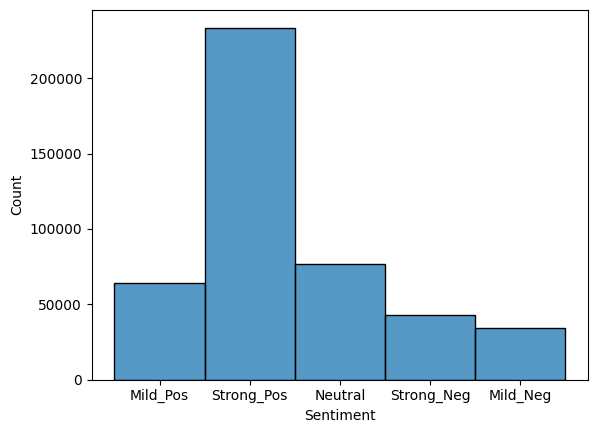

In [47]:
print(sentiment_data['Sentiment'].value_counts())
sns.histplot(sentiment_data['Sentiment'])

Seems like bit of class imbalance
Strong_Positive class has overshadowed other class. So Need to apply some technique to Make it balance. Some of the technique which can be used are 
- Undersampling :- Reducing the data from the majority Class
- Oversampling :- Increasing the data from the minority class to match it with the majority class

Python Library to solve Class Imbalance - Smote, imblearn(Imbalance learn)

Better practice is to solve class imbalance after splitting the data in train, test. We don't want to disturb the distrubution of test data

# Pre-Processing 

#### There are lots of things which we have to do to preprocess the text data
- Handle Emojis, Slangs, Punctuations, ShortForm
- Spelling Corrections
- POS Tagging 
- Handling Pronouns and Special Characters
- Tokenize
- Remove Stop Words
- Negation Handled
- Stemming and Lemmatization
- Lowercase and En-grams



In [48]:
from slang_dict import abbreviations
def convert_abbrev(word):
    final_word = []
    for i in word.split(" "):
        final_word.append(abbreviations[i.lower()] if i.lower() in abbreviations.keys() else i)
    return " ".join(final_word)

In [49]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [50]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [51]:
def remove_unnecessary_digits(text):
    pattern = r'\b\d+\b|(\d{4}-\d{2}-\d{2})|\b\d+\s*(?=\w)'  
    
    # Remove matched patterns
    cleaned_text = re.sub(pattern, '', text)
    
    # Remove extra whitespace
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text

In [52]:
def Negation(sentence):	
  '''
  Input: Tokenized sentence (List of words)
  Output: Tokenized sentence with negation handled (List of words)
  '''
  temp = int(0)
  for i in range(len(sentence)):
      if sentence[i-1] in ['not',"n't"]:
          antonyms = []
          for syn in wordnet.synsets(sentence[i]):
              syns = wordnet.synsets(sentence[i])
              w1 = syns[0].name()
              temp = 0
              for l in syn.lemmas():
                  if l.antonyms():
                      antonyms.append(l.antonyms()[0].name())
              max_dissimilarity = 0
              for ant in antonyms:
                  syns = wordnet.synsets(ant)
                  w2 = syns[0].name()
                  syns = wordnet.synsets(sentence[i])
                  w1 = syns[0].name()
                  word1 = wordnet.synset(w1)
                  word2 = wordnet.synset(w2)
                  if isinstance(word1.wup_similarity(word2), float) or isinstance(word1.wup_similarity(word2), int):
                      temp = 1 - word1.wup_similarity(word2)
                  if temp>max_dissimilarity:
                      max_dissimilarity = temp
                      antonym_max = ant
                      sentence[i] = antonym_max
                      sentence[i-1] = ''
  while '' in sentence:
    try:
        sentence.remove('')
    except:
        pass
    
  return sentence

In [53]:
def lemmatize_text_nltk(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)  # Tokenize the text
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

In [54]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))  # Get the set of English stopwords
    words = word_tokenize(text)  # Tokenize the text
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [55]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [56]:
def cleaning_username(text):
    return re.sub('@[^\s]+', ' ', text)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_13716\3753787498.py:2: SyntaxWarning: invalid escape sequence '\s'
  return re.sub('@[^\s]+', ' ', text)


In [57]:

def preprocessing(text):

    # Handling Emoji's
    text = emoji.demojize(text)

    # Handling URLS, HTML tags
    text = remove_urls(text)
    text = remove_html(text)

    # Handling Short Form and Slang
    text = convert_abbrev(text)

    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    
    # Handling Digits
    text = remove_unnecessary_digits(text)

    # Handling Spell Correction 
    ## This method works well when you have smaller dataset 
    # textblob = TextBlob(text)
    # text = str(textblob.correct())

    # Remove stopwords
    text = remove_stopwords(text)
    
    # Handling Negation
    # text = Negation(" ".join(text.split(" ")))

    text = cleaning_repeating_char(text)
    text = cleaning_username(text)

    # Lemmatization
    text = lemmatize_text_nltk(text)

    text = text.lower()

    return text
    
    

In [58]:
sentiment_data['Preprocessed_Tweet'] = sentiment_data['Tweet'].apply(preprocessing)

In [59]:
sentiment_data['Preprocessed_Tweet'][0]

'angelicatoy hapy aniversarythe day fredumb died tune mcleans american pie fredumbconvoy fredumbers flutruxklan convoywatch convoy fredomconvoy'

In [60]:
X = sentiment_data['Preprocessed_Tweet']
y = sentiment_data['Sentiment']


Now, We have our dependent and independent variable, We need to create embedding of our data for machine to understand


**Word Embedding:** Word embeddings transform textual data, which machine learning algorithms can’t understand, into a numerical form they can comprehend. In addition, they can be used to capture the contextual essence of words, their semantic and syntactic similarity, and their relation with other words. 

1. **TF-IDF(Term Frequency-Inverse Document Frequency):** In the context of word embeddings, TF-IDF can be thought of as a very basic embedding technique, where words are represented as vectors of their TF-IDF scores across multiple documents. Despite its simplicity, TF-IDF can be effective in tasks such as information retrieval and text classification. <br>
**TF** = (Frequency of a word in the document) / (Total number of words in the document)<br>
**IDF** = log(total number of documents / number of documents including the word)<br>
**TF-IDF = (TF * IDF)**

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
X_train

312438    whats caled fredomconvoy also coming peace bri...
11526     exact thing hapening canada fredom convoy even...
330111    ashleypromyse folowing gave wanted donât agr...
99924     markjmager thats god loks like trump started t...
199961    âfredom convoyâ already taken media contai...
                                ...                        
259204    could lose everything canadas fredom convoy le...
365873    thejagmetsingh silence fredom convoy speaks vo...
131948    justice mentioned tamara lich would believed a...
146884    ð¨ð¦ mudede canada fredom convoy vancouver...
121974    scribulatora dumbshowsnoise paramilitia atacke...
Name: Preprocessed_Tweet, Length: 361036, dtype: object

#### TfIdf With Unigram

In [63]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [64]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [65]:

random_under_sample = RandomUnderSampler(random_state=42, replacement=True)
X_train_resampled, y_train_resampled = random_under_sample.fit_resample(X_train, y_train)

In [66]:
for i in [0, 1, 2, 3, 4]:
    print(f"count of {i} is: {y_train.tolist().count(i)}")

count of 0 is: 27171
count of 1 is: 51136
count of 2 is: 61636
count of 3 is: 33963
count of 4 is: 187130


In [67]:
for i in [0, 1, 2, 3, 4]:
    print(f"count of {i} is: {y_train_resampled.tolist().count(i)}")

count of 0 is: 27171
count of 1 is: 27171
count of 2 is: 27171
count of 3 is: 27171
count of 4 is: 27171


In [68]:
svc = LinearSVC()
svc.fit(X_train_resampled, y_train_resampled)

LinearSVC()

In [69]:
y_pred = svc.predict(X_test)

In [70]:
accuracy_score(y_test, y_pred)

0.6308512170531471

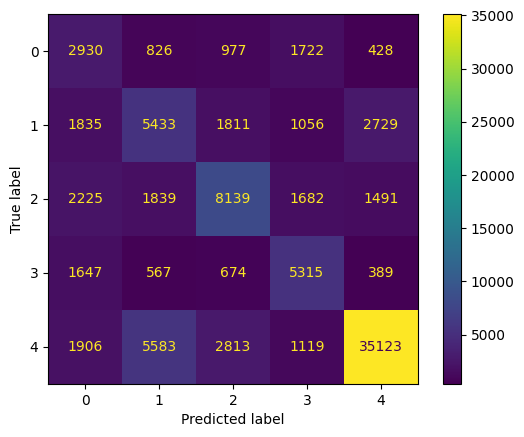

In [71]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

### TF-IDF with Bigram(2, 2)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
vectorizer = TfidfVectorizer(ngram_range=(2, 2))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [74]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [75]:
random_under_sample = RandomUnderSampler(random_state=42, replacement=True)
X_train_resampled, y_train_resampled = random_under_sample.fit_resample(X_train, y_train)

In [76]:
svc = LinearSVC()
svc.fit(X_train_resampled, y_train_resampled)

LinearSVC()

In [77]:
y_pred = svc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.6030091182042788

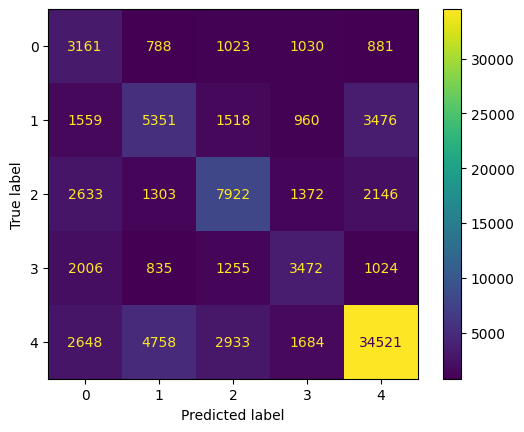

In [78]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

**Word2vec:** Developed by google in 2013. It uses either skip-gram or continious Bag of words
<br>It uses the cosine similarity metric to measure semantic similarity. Cosine similarity is equal to Cos(angle) where the angle is measured between the vector representation of two words/documents.
<br>
So if the cosine angle is one, it means that the words are overlapping.
And if the cosine angle is a right angle or 90°, It means words hold no contextual similarity and are independent of each other.

**1. CBOW(Continious Bag of Word):** In CBOW, we define a window size. The middle word is the current word and the surrounding words (past and future words) are the context. CBOW utilizes the context to predict the current words. Each word is encoded using One Hot Encoding in the defined vocabulary and sent to the CBOW neural network.

**2. Skip-Gram:** It takes only one word as an input and then predicts the closely related context words. That is the reason it can efficiently represent rare words.

**CBOW is faster to train and tends to perform well with frequent words, making it suitable for smaller datasets. In contrast, Skip-Gram is more effective with rare words and captures better semantic relationships between words**

In [79]:
def tokenize_tweet(text):
    return word_tokenize(text)

sentiment_data['tokenize_tweet'] = X.apply(tokenize_tweet)

In [80]:
from gensim.models import Word2Vec
cbow_model = Word2Vec(sentences=sentiment_data['tokenize_tweet'], window=5, vector_size = 100)

In [81]:
def get_document_embedding(document):
    word_vectors = [cbow_model.wv[word] for word in document if word in cbow_model.wv.key_to_index]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(cbow_model.vector_size)

sentiment_data['embedding'] = sentiment_data['tokenize_tweet'].apply(lambda doc: get_document_embedding([word for word in doc if word in cbow_model.wv.key_to_index]))

In [82]:
X = np.array(sentiment_data['embedding']).tolist()
y = sentiment_data['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [84]:
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC()

In [85]:
y_pred = svc.predict(X_test)

In [86]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy * 100)

60.991147697182555


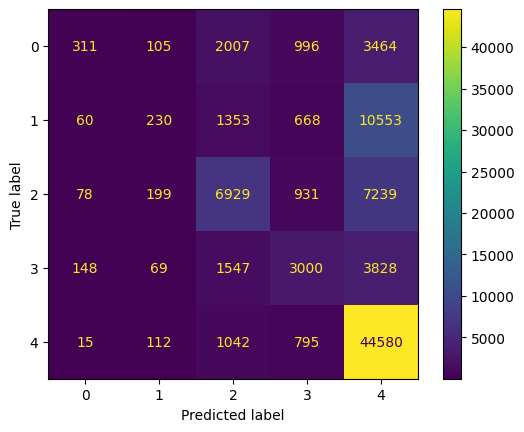

In [87]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

In [88]:
skipgram_model = Word2Vec(sentences=sentiment_data['tokenize_tweet'], window=5, vector_size = 100, sg=1)

In [89]:
def get_document_embedding(document):
    word_vectors = [skipgram_model.wv[word] for word in document if word in skipgram_model.wv.key_to_index]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(skipgram_model.vector_size)

sentiment_data['skipgram_embedding'] = sentiment_data['tokenize_tweet'].apply(lambda doc: get_document_embedding([word for word in doc if word in skipgram_model.wv.key_to_index]))

In [90]:
X = np.array(sentiment_data['skipgram_embedding']).tolist()
y = sentiment_data['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [91]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [92]:
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC()

60.69090063040805


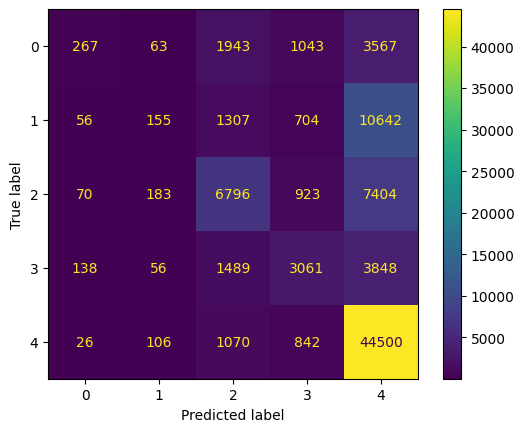

In [93]:
y_pred = svc.predict(X_test)
print(accuracy_score(y_test, y_pred) * 100)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

In [94]:
# # Hyperparameter tuning
# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'penalty': ['l2'],
#     'loss': ['squared_hinge'],
#     'dual': [ False]
# }

# grid = GridSearchCV(svc, param_grid, verbose=3)
# grid.fit(X_train, y_train)

In [95]:
# grid.best_params_

In [96]:
# grid.best_estimator_

In [97]:
# y_pred = grid.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)

In [98]:
# accuracy

**CountVectorizer:** Just Like Tf-IDF, It converts text into numerical form

In [99]:
X_train, X_test, y_train, y_test = train_test_split(sentiment_data['Preprocessed_Tweet'], sentiment_data['Sentiment'], stratify=sentiment_data['Sentiment'])

In [100]:
sentiment_data['Tweet'][0]

'@_angelica_toy Happy Anniversary!!!....The Day the FreeDUMB Died (In the tune of Don McLean\'s "American Pie") #FreeDumbConvoy #Freedumbers #FluTruxKlan #convoywatch #convoy #FreedomConvoy   https://t.co/ZT1cIPwmh9'

In [101]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [102]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [103]:
# random_under_sample = RandomUnderSampler(random_state=42, replacement=True)
# X_train_resampled, y_train_resampled = random_under_sample.fit_resample(X_train_vectorized, y_train)

In [104]:
for i in [0, 1, 2, 3, 4]:
    print(f"count of {i} is {y_train.tolist().count(i)}")

count of 0 is 25541
count of 1 is 48000
count of 2 is 57759
count of 3 is 31916
count of 4 is 175255


In [106]:
svc = LinearSVC()
svc.fit(X_train_vectorized, y_train)


c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [107]:
for i in [0, 1, 2, 3, 4]:
    print(f"count of {i} is {y_test.tolist().count(i)}")

count of 0 is 8513
count of 1 is 16000
count of 2 is 19253
count of 3 is 10639
count of 4 is 58419


Train Accuracy: 0.998
Test Accuracy: 0.733

Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25541
           1       1.00      1.00      1.00     48000
           2       1.00      1.00      1.00     57759
           3       1.00      1.00      1.00     31916
           4       1.00      1.00      1.00    175255

    accuracy                           1.00    338471
   macro avg       1.00      1.00      1.00    338471
weighted avg       1.00      1.00      1.00    338471


Test Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.34      0.41      8513
           1       0.55      0.44      0.49     16000
           2       0.63      0.68      0.65     19253
           3       0.61      0.56      0.59     10639
           4       0.84      0.92      0.88     58419

    accuracy                           0.73    112824
   macro avg       0.63      

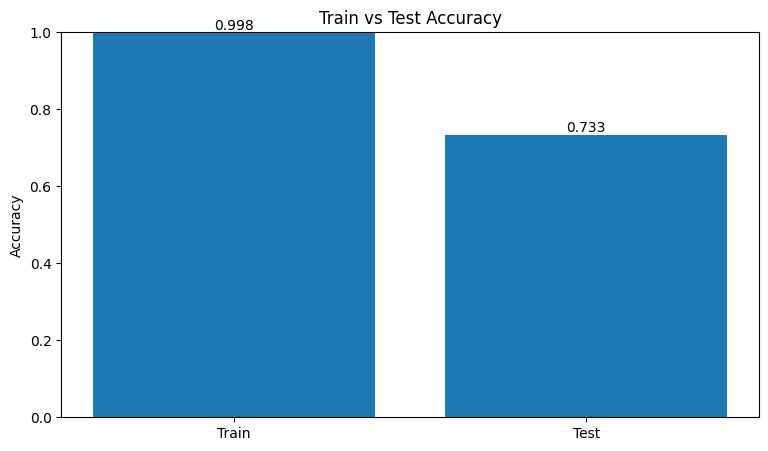

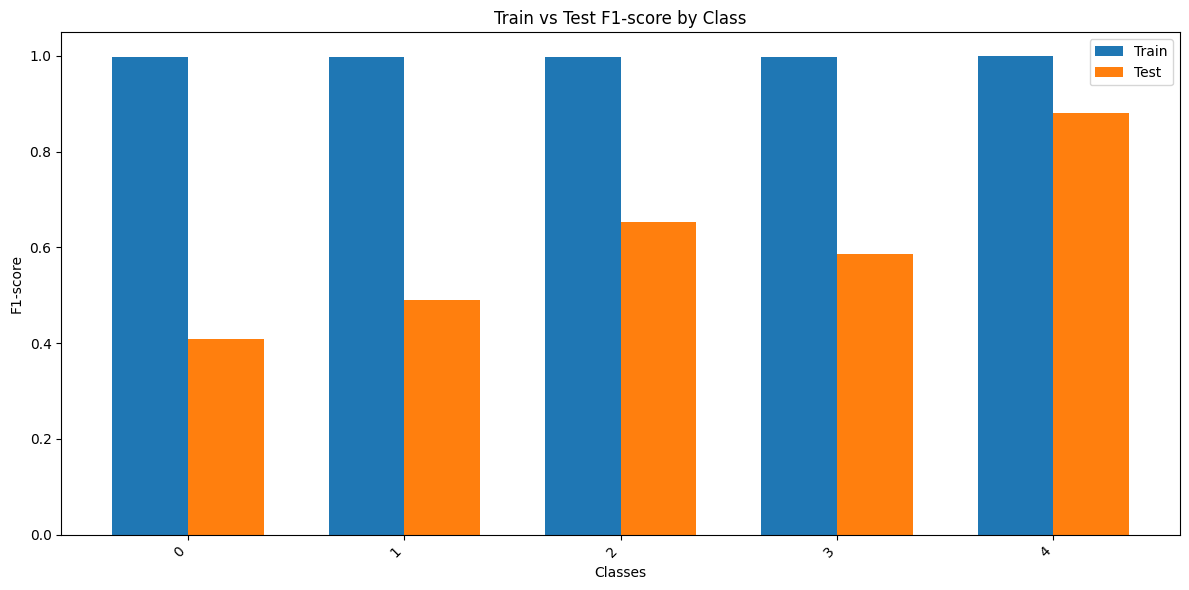

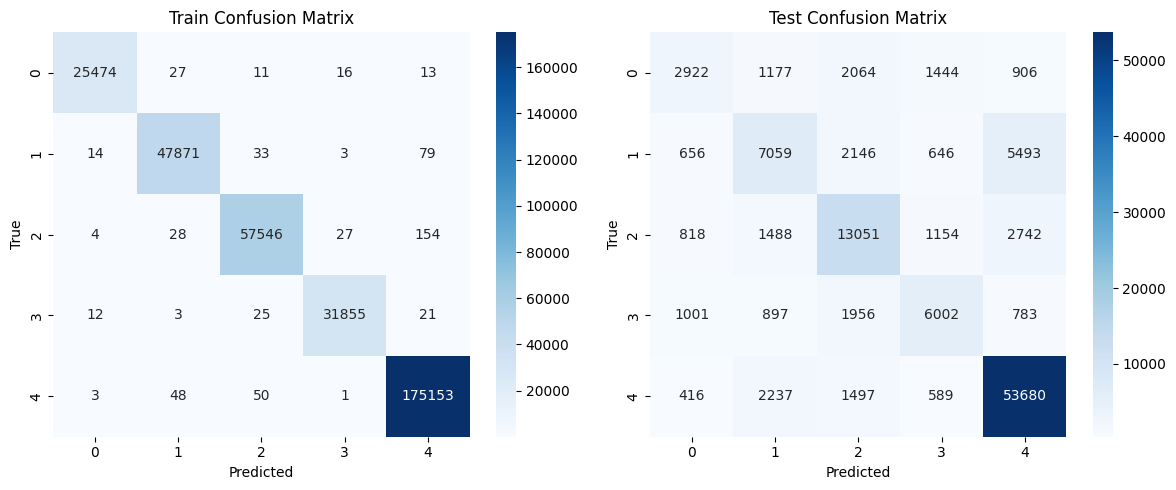

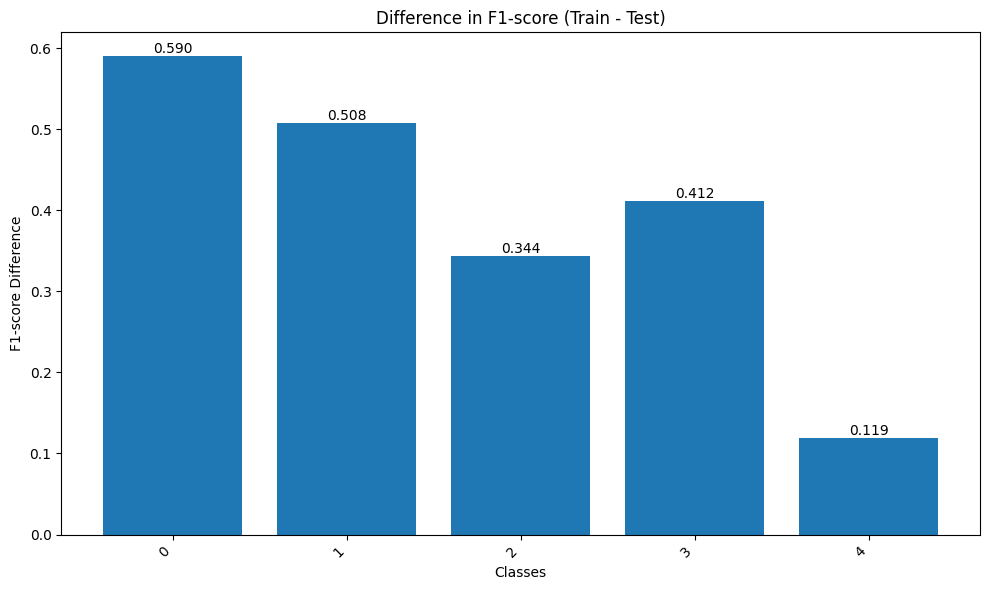

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Predicting on train test data
y_train_pred = svc.predict(X_train_vectorized)
y_test_pred = svc.predict(X_test_vectorized)

# Calculating accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Generating classification reports
train_report = classification_report(y_train, y_train_pred, output_dict=True)
test_report = classification_report(y_test, y_test_pred, output_dict=True)

#Printing Accuracies
print(f"Train Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")

#Printing classification reports
print("\nTrain Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

# Visualizing Accuracies
plt.figure(figsize=(9, 5))
plt.bar(['Train', 'Test'], [train_accuracy, test_accuracy])
plt.title('Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate([train_accuracy, test_accuracy]):
    plt.text(i, v, f'{v:.3f}', ha='center', va='bottom')
plt.show()

# Visualizing performance by class
classes = list(train_report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'
train_f1 = [train_report[c]['f1-score'] for c in classes]
test_f1 = [test_report[c]['f1-score'] for c in classes]

plt.figure(figsize=(12, 6))
x = np.arange(len(classes))
width = 0.35
plt.bar(x - width/2, train_f1, width, label='Train')
plt.bar(x + width/2, test_f1, width, label='Test')
plt.xlabel('Classes')
plt.ylabel('F1-score')
plt.title('Train vs Test F1-score by Class')
plt.xticks(x, classes, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion matrices
plt.figure(figsize=(12, 5))

plt.subplot(121)
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(122)
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

# Performance difference
diff_f1 = np.array(train_f1) - np.array(test_f1)
plt.figure(figsize=(10, 6))
plt.bar(classes, diff_f1)
plt.title('Difference in F1-score (Train - Test)')
plt.xlabel('Classes')
plt.ylabel('F1-score Difference')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(diff_f1):
    plt.text(i, v, f'{v:.3f}', ha='center', va='bottom' if v > 0 else 'top')
plt.tight_layout()
plt.show()

Big Overfitting Issue.
Because of class imbalance 

Accuracy with class Balanced
- Train - 0.99
- Test - 0.66

Accuracy with class Imbalanced
- Train - 0.99
- Test - 0.73

### Glove(Global Vector for word representation)
It tries to find out the co-occurence matrix between words in a sentence and that is how it creates Embeddings.
<br>The primary idea behind the GloVe word embedding is to use statistics to derive the link between the words. Unlike the occurrence matrix, the co-occurrence matrix informs you how frequently a specific word pair appears together. Each value represents a pair of words that occur together in the co-occurrence matrix.

Let's try Glove Embeddings

In [109]:
sentiment_data.head(5)

,Tweet,Sentiment,Preprocessed_Tweet,tokenize_tweet,embedding,skipgram_embedding
0,@_angelica_toy Happy Anniversary!!!....The Day...,Mild_Pos,angelicatoy hapy aniversarythe day fredumb die...,"[angelicatoy, hapy, aniversarythe, day, fredum...","[0.24319667, -0.78203595, 0.12759374, 0.191606...","[0.30945972, -0.06367662, 0.1147492, 0.0483863..."
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,Mild_Pos,mcfarlaneglenda hapy aniversarythe day fredumb...,"[mcfarlaneglenda, hapy, aniversarythe, day, fr...","[0.23664936, -0.7848489, 0.1291369, 0.19117184...","[0.31897977, -0.07375894, 0.11117061, 0.052882..."
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,Mild_Pos,thevivafrei justintrudeau hapy aniversarythe d...,"[thevivafrei, justintrudeau, hapy, aniversaryt...","[0.12331546, -0.82672954, 0.05460666, 0.133076...","[0.26090717, -0.07651556, 0.117038995, 0.01892..."
3,@NChartierET Happy Anniversary!!!....The Day t...,Mild_Pos,nchartieret hapy aniversarythe day fredumb die...,"[nchartieret, hapy, aniversarythe, day, fredum...","[0.24349356, -0.7749146, 0.1196446, 0.19405505...","[0.3132842, -0.060888045, 0.110588335, 0.05515..."
4,@tabithapeters05 Happy Anniversary!!!....The D...,Mild_Pos,tabithapeters05 hapy aniversarythe day fredumb...,"[tabithapeters05, hapy, aniversarythe, day, fr...","[0.26091722, -0.8382089, 0.1315374, 0.20423764...","[0.32606682, -0.07156841, 0.11006836, 0.050364..."


In [110]:
import numpy as np
from collections import defaultdict

corpus = sentiment_data['Preprocessed_Tweet']
# Initialize vocabulary and co-occurrence matrix
vocab = set()
co_occurrence = defaultdict(float)

window_size = 4
# Iterate through the corpus to build vocabulary and co-occurrence matrix
for sentence in corpus:
    words = sentence.split()
    for i in range(len(words)):
        word = words[i]
        vocab.add(word)
        for j in range(max(0, i - window_size), min(i + window_size + 1, len(words))):
            if i != j:
                co_occurrence[(word, words[j])] += 1.0 / abs(i - j)

In [111]:
embedding_dim = 10
word_embeddings = {
    word: np.random.randn(embedding_dim) for word in vocab
}

In [113]:
import numpy as np

# Path to your downloaded GloVe file
glove_file = 'glove.6B.100d.txt/glove.6B.100d.txt'

# Create a dictionary to store the GloVe embeddings
embedding_dict = {}

# Load the GloVe model
with open(glove_file, 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_dict[word] = vector




In [114]:
# Function to convert tweet to vector
def tweet_to_vector(tweet, embedding_dict):
    words = tweet.split()
    vectors = []
    for word in words:
        if word in embedding_dict:
            vectors.append(embedding_dict[word])
    if len(vectors) == 0:
        return np.zeros(100)  # Return a zero vector if no words are found
    return np.mean(vectors, axis=0)  # Average the vectors

In [115]:
# Convert tweets to vectors
sentiment_data['glove_embedding'] = sentiment_data['Preprocessed_Tweet'].apply(lambda x: tweet_to_vector(x, embedding_dict))

# Create X (features) and y (labels)
X = np.array(sentiment_data['glove_embedding'].tolist())

In [116]:
y = np.array(sentiment_data['Sentiment'])

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [118]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [119]:
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC()

Train Accuracy: 0.579
Test Accuracy: 0.576

Train Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.02      0.04     27171
           1       0.16      0.01      0.01     51136
           2       0.55      0.27      0.36     61636
           3       0.45      0.31      0.37     33963
           4       0.59      0.97      0.74    187130

    accuracy                           0.58    361036
   macro avg       0.45      0.31      0.30    361036
weighted avg       0.50      0.58      0.48    361036


Test Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.02      0.04      6883
           1       0.14      0.01      0.01     12864
           2       0.54      0.27      0.36     15376
           3       0.46      0.31      0.37      8592
           4       0.59      0.97      0.73     46544

    accuracy                           0.58     90259
   macro avg       0.45      

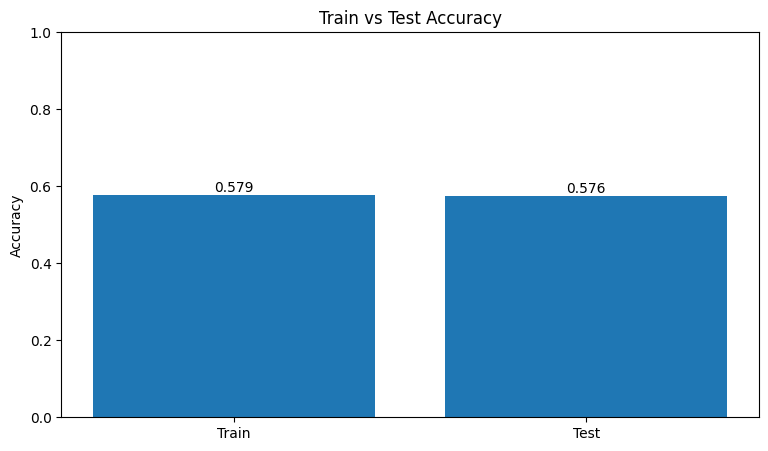

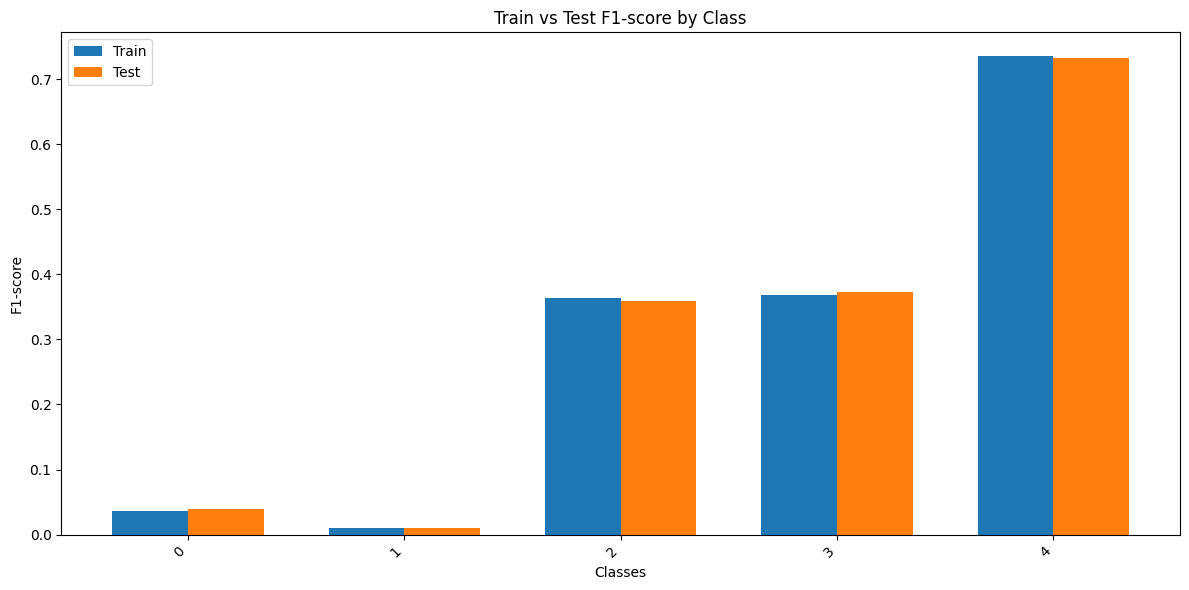

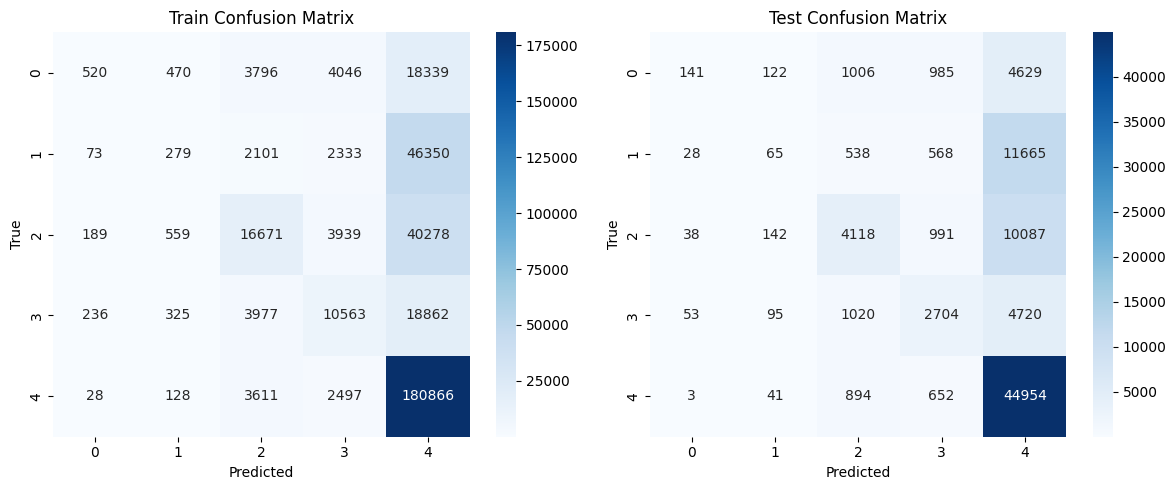

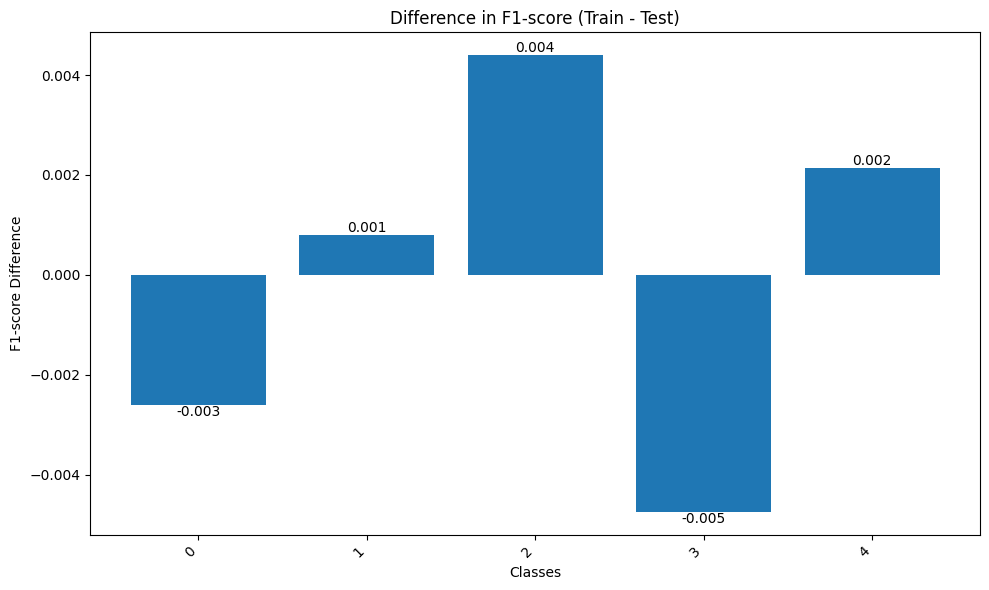

In [120]:

# Predicting on train test data
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

# Calculating accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Generating classification reports
train_report = classification_report(y_train, y_train_pred, output_dict=True)
test_report = classification_report(y_test, y_test_pred, output_dict=True)

#Printing Accuracies
print(f"Train Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")

#Printing classification reports
print("\nTrain Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

# Visualizing Accuracies
plt.figure(figsize=(9, 5))
plt.bar(['Train', 'Test'], [train_accuracy, test_accuracy])
plt.title('Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate([train_accuracy, test_accuracy]):
    plt.text(i, v, f'{v:.3f}', ha='center', va='bottom')
plt.show()

# Visualizing performance by class
classes = list(train_report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'
train_f1 = [train_report[c]['f1-score'] for c in classes]
test_f1 = [test_report[c]['f1-score'] for c in classes]

plt.figure(figsize=(12, 6))
x = np.arange(len(classes))
width = 0.35
plt.bar(x - width/2, train_f1, width, label='Train')
plt.bar(x + width/2, test_f1, width, label='Test')
plt.xlabel('Classes')
plt.ylabel('F1-score')
plt.title('Train vs Test F1-score by Class')
plt.xticks(x, classes, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion matrices
plt.figure(figsize=(12, 5))

plt.subplot(121)
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(122)
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

# Performance difference
diff_f1 = np.array(train_f1) - np.array(test_f1)
plt.figure(figsize=(10, 6))
plt.bar(classes, diff_f1)
plt.title('Difference in F1-score (Train - Test)')
plt.xlabel('Classes')
plt.ylabel('F1-score Difference')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(diff_f1):
    plt.text(i, v, f'{v:.3f}', ha='center', va='bottom' if v > 0 else 'top')
plt.tight_layout()
plt.show()

# Let's Try FastText


Word embedding techniques like **word2vec and GloVe** provide distinct vector representations for the words in the vocabulary. This leads to ignorance of the internal structure of the language. This is a limitation for morphologically rich language as it ignores the syntactic relation of the words

- FastText provides embeddings for character n-grams, representing words as the average of these embeddings. 
- It can handle **OOV(Out of Vocabulary)** words as well
- Out-of-vocabulary (OOV) words are words that do not occur while training the data and are not present in the model’s vocabulary. Word embedding models like word2vec or GloVe cannot provide embeddings for the OOV words because they provide embeddings for words; hence, if a new word occurs, it cannot provide embedding.
- Since FastText provides embeddings for character n-grams, it can provide embeddings for OOV words. If an OOV word occurs, then fastText provides embedding for that word by embedding its character n-gram.

In [122]:
fasttext_model = FastText(sentences=sentiment_data['tokenize_tweet'], window=5, vector_size = 100, sg=1)
def get_document_embedding(document):
    word_vectors = [fasttext_model.wv[word] for word in document if word in fasttext_model.wv.key_to_index]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(fasttext_model.vector_size)

sentiment_data['fasttext_embedding'] = sentiment_data['tokenize_tweet'].apply(lambda doc: get_document_embedding([word for word in doc if word in fasttext_model.wv.key_to_index]))

X = np.array(sentiment_data['fasttext_embedding']).tolist()
y = sentiment_data['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [123]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)


In [124]:
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC()

Train Accuracy: 0.610
Test Accuracy: 0.606

Train Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.04      0.08     27171
           1       0.25      0.01      0.02     51136
           2       0.54      0.44      0.49     61636
           3       0.47      0.36      0.41     33963
           4       0.64      0.96      0.77    187130

    accuracy                           0.61    361036
   macro avg       0.48      0.36      0.35    361036
weighted avg       0.54      0.61      0.53    361036


Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.04      0.08      6883
           1       0.29      0.01      0.02     12864
           2       0.54      0.43      0.48     15376
           3       0.47      0.37      0.41      8592
           4       0.63      0.96      0.76     46544

    accuracy                           0.61     90259
   macro avg       0.49      

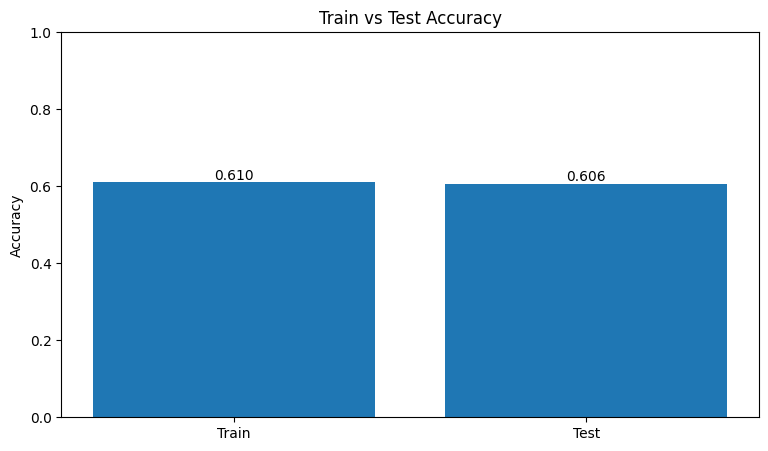

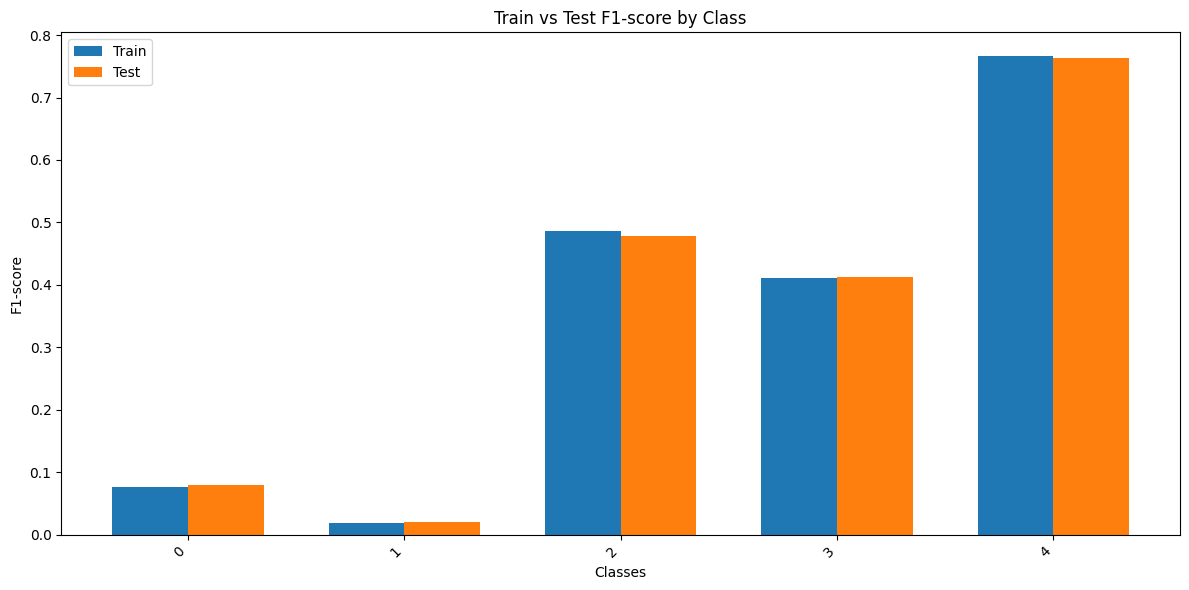

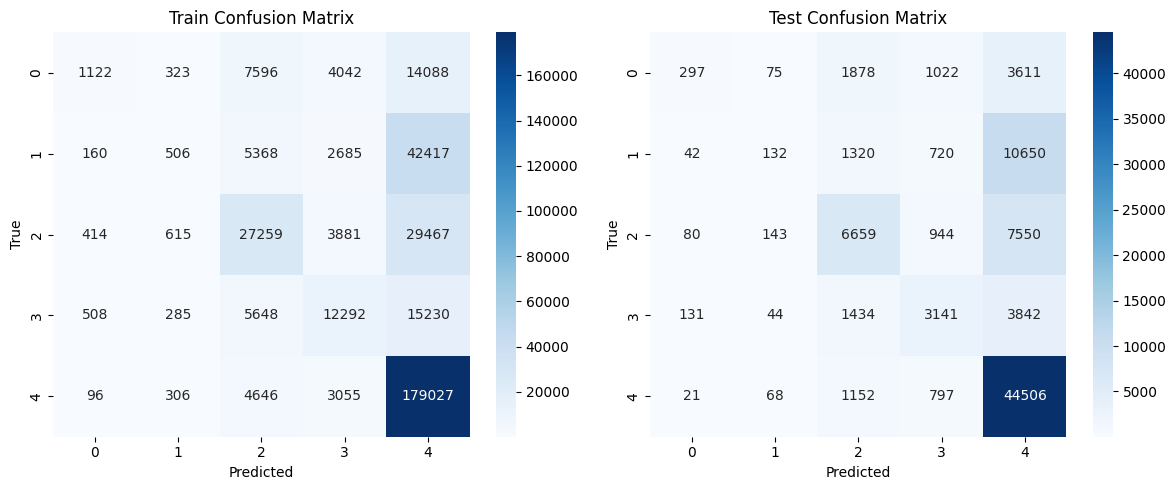

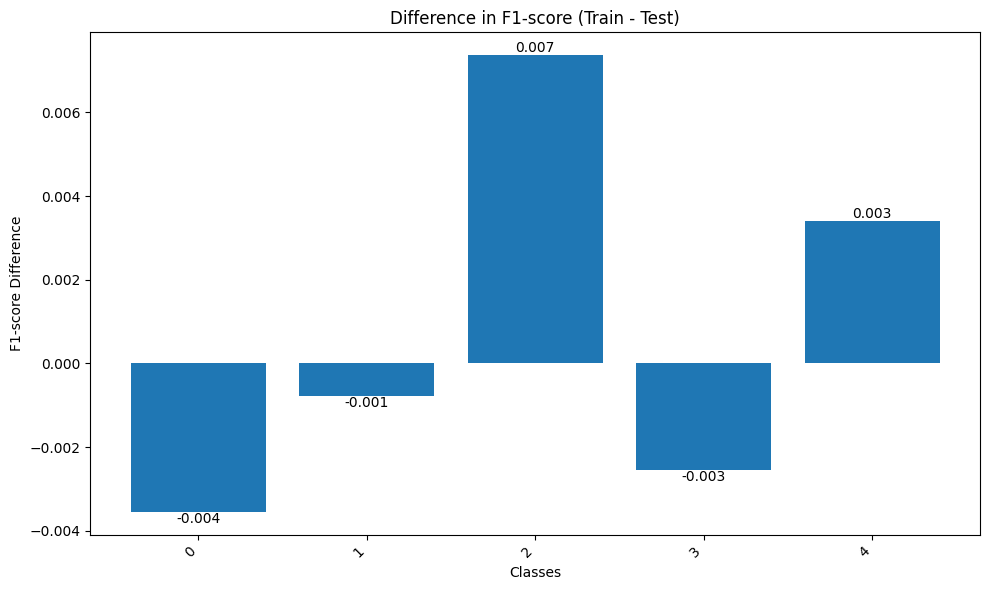

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Predicting on train test data
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

# Calculating accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Generating classification reports
train_report = classification_report(y_train, y_train_pred, output_dict=True)
test_report = classification_report(y_test, y_test_pred, output_dict=True)

#Printing Accuracies
print(f"Train Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")

#Printing classification reports
print("\nTrain Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

# Visualizing Accuracies
plt.figure(figsize=(9, 5))
plt.bar(['Train', 'Test'], [train_accuracy, test_accuracy])
plt.title('Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate([train_accuracy, test_accuracy]):
    plt.text(i, v, f'{v:.3f}', ha='center', va='bottom')
plt.show()

# Visualizing performance by class
classes = list(train_report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'
train_f1 = [train_report[c]['f1-score'] for c in classes]
test_f1 = [test_report[c]['f1-score'] for c in classes]

plt.figure(figsize=(12, 6))
x = np.arange(len(classes))
width = 0.35
plt.bar(x - width/2, train_f1, width, label='Train')
plt.bar(x + width/2, test_f1, width, label='Test')
plt.xlabel('Classes')
plt.ylabel('F1-score')
plt.title('Train vs Test F1-score by Class')
plt.xticks(x, classes, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion matrices
plt.figure(figsize=(12, 5))

plt.subplot(121)
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(122)
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

# Performance difference
diff_f1 = np.array(train_f1) - np.array(test_f1)
plt.figure(figsize=(10, 6))
plt.bar(classes, diff_f1)
plt.title('Difference in F1-score (Train - Test)')
plt.xlabel('Classes')
plt.ylabel('F1-score Difference')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(diff_f1):
    plt.text(i, v, f'{v:.3f}', ha='center', va='bottom' if v > 0 else 'top')
plt.tight_layout()
plt.show()

Let's Try
RNN, LSTM

In [127]:
from keras.models import Sequential
from tensorflow.keras.regularizers import l2
from keras.layers import Embedding, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU

In [128]:
sentiment_data.head(5)

,Tweet,Sentiment,Preprocessed_Tweet,tokenize_tweet,embedding,skipgram_embedding,glove_embedding,fasttext_embedding
0,@_angelica_toy Happy Anniversary!!!....The Day...,Mild_Pos,angelicatoy hapy aniversarythe day fredumb die...,"[angelicatoy, hapy, aniversarythe, day, fredum...","[0.24319667, -0.78203595, 0.12759374, 0.191606...","[0.30945972, -0.06367662, 0.1147492, 0.0483863...","[-0.2519684, 0.17554286, 0.022171428, -0.11215...","[-0.06011809, 0.1190479, -0.015039051, 0.25374..."
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,Mild_Pos,mcfarlaneglenda hapy aniversarythe day fredumb...,"[mcfarlaneglenda, hapy, aniversarythe, day, fr...","[0.23664936, -0.7848489, 0.1291369, 0.19117184...","[0.31897977, -0.07375894, 0.11117061, 0.052882...","[-0.2519684, 0.17554286, 0.022171428, -0.11215...","[-0.032030188, 0.10747703, -0.0184324, 0.23322..."
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,Mild_Pos,thevivafrei justintrudeau hapy aniversarythe d...,"[thevivafrei, justintrudeau, hapy, aniversaryt...","[0.12331546, -0.82672954, 0.05460666, 0.133076...","[0.26090717, -0.07651556, 0.117038995, 0.01892...","[-0.2519684, 0.17554286, 0.022171428, -0.11215...","[-0.026292514, 0.068072185, -0.028098598, 0.22..."
3,@NChartierET Happy Anniversary!!!....The Day t...,Mild_Pos,nchartieret hapy aniversarythe day fredumb die...,"[nchartieret, hapy, aniversarythe, day, fredum...","[0.24349356, -0.7749146, 0.1196446, 0.19405505...","[0.3132842, -0.060888045, 0.110588335, 0.05515...","[-0.2519684, 0.17554286, 0.022171428, -0.11215...","[-0.047326226, 0.09310898, -0.031547025, 0.233..."
4,@tabithapeters05 Happy Anniversary!!!....The D...,Mild_Pos,tabithapeters05 hapy aniversarythe day fredumb...,"[tabithapeters05, hapy, aniversarythe, day, fr...","[0.26091722, -0.8382089, 0.1315374, 0.20423764...","[0.32606682, -0.07156841, 0.11006836, 0.050364...","[-0.2519684, 0.17554286, 0.022171428, -0.11215...","[-0.042655487, 0.12252581, -0.017378999, 0.229..."


In [137]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(sentiment_data['Preprocessed_Tweet'][:50000])
sequences = tokenizer.texts_to_sequences(sentiment_data['Preprocessed_Tweet'][:50000])
padded_sequences = pad_sequences(sequences, maxlen=512)

In [140]:
X = padded_sequences
y = sentiment_data['Sentiment'][:50000]

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [142]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [143]:
from tensorflow.keras.utils import to_categorical
y_train_onehot = to_categorical(y_train, num_classes=len(label_encoder.classes_))
y_test_onehot = to_categorical(y_test, num_classes=len(label_encoder.classes_))

In [144]:
from tensorflow.keras.layers import SimpleRNN
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=1024))
model.add(SimpleRNN(128))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, 512))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 512, 1024)      │    10,240,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,388,229 (39.63 MB)

 Trainable params: 10,388,229 (39.63 MB)

 Non-trainable params: 0 (0.00 B)

In [145]:
model.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_data=(X_test, y_test_onehot))


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 529s 413ms/step - accuracy: 0.5915 - loss: 1.1439 - val_accuracy: 0.6344 - val_loss: 1.0097
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 486s 389ms/step - accuracy: 0.6665 - loss: 0.9136 - val_accuracy: 0.6779 - val_loss: 0.9000
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 471s 377ms/step - accuracy: 0.7322 - loss: 0.7486 - val_accuracy: 0.6882 - val_loss: 0.8684
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 463s 370ms/step - accuracy: 0.7675 - loss: 0.6607 - val_accuracy: 0.6871 - val_loss: 0.9150
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 482s 385ms/step - accuracy: 0.8030 - loss: 0.5723 - val_accuracy: 0.6480 - val_loss: 0.9946
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 491s 393ms/step - accuracy: 0.8275 - loss: 0.5122 - val_accuracy: 0.6732 - val_loss: 0.9878
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 495s 396ms/step - accuracy: 0.8548 - loss: 0.4433 - val_accuracy: 0.6678 - val_loss: 1.0235
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 525s 420ms/step - ac

In [147]:
loss, accuracy = model.evaluate(X_test, y_test_onehot)
print(f'Loss: {loss}, Accuracy: {accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.6599 - loss: 1.1615
Loss: 1.1658304929733276, Accuracy: 0.6626999974250793


313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step
ROC AUC: 0.8327608371862836
F1-Score: 0.5262730938745814


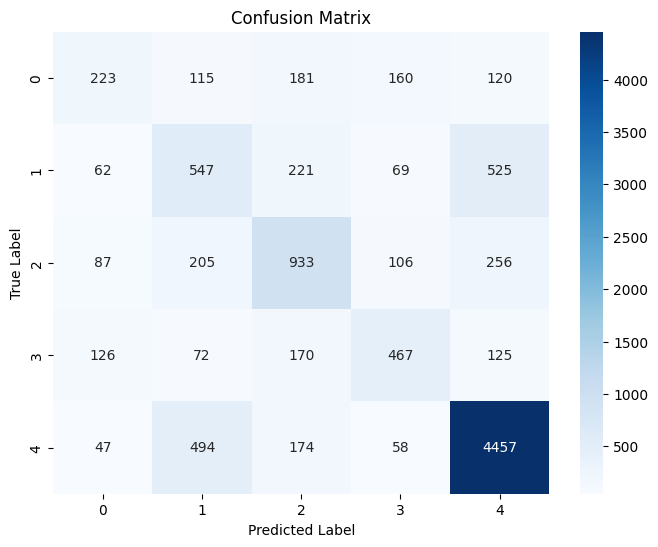

In [148]:
from sklearn.metrics import roc_auc_score, f1_score
y_pred_prob = model.predict(X_test)  # Predicted probabilities
y_pred_class = np.argmax(y_pred_prob, axis=1)  # Predicted classes


roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class="ovr", average="macro") # ROC AUC score
print(f"ROC AUC: {roc_auc}")

conf_matrix = confusion_matrix(y_test, y_pred_class) #Confusion Matrix


f1 = f1_score(y_test, y_pred_class, average='macro') # F1-Score
print(f"F1-Score: {f1}")


#Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

RNN Didn't Performed that well as expected.
<br> Let's try with more advanced algorithm LSTM

# LSTM

In [ ]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(sentiment_data['Preprocessed_Tweet'][:10000])
sequences = tokenizer.texts_to_sequences(sentiment_data['Preprocessed_Tweet'][:10000])
padded_sequences = pad_sequences(sequences, maxlen=512)

X = padded_sequences
y = sentiment_data['Sentiment'][:10000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

y_train_onehot = to_categorical(y_train, num_classes=len(label_encoder.classes_))
y_test_onehot = to_categorical(y_test, num_classes=len(label_encoder.classes_))


In [150]:
from tensorflow.keras.layers import BatchNormalization
# Define Model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=512))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(LSTM(50))
model.add(BatchNormalization())
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

In [151]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, 512))
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 512, 512)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 512, 50)        │       112,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512, 50)        │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,253,455 (20.04 MB)

 Trainable params: 5,253,255 (20.04 MB)

 Non-trainable params: 200 (800.00 B)

In [152]:
# Train the model
history = model.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_data=(X_test, y_test_onehot))


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 560s 443ms/step - accuracy: 0.5865 - loss: 1.1445 - val_accuracy: 0.6972 - val_loss: 0.8389
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 517s 413ms/step - accuracy: 0.7431 - loss: 0.7125 - val_accuracy: 0.6936 - val_loss: 0.8376
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 515s 412ms/step - accuracy: 0.8035 - loss: 0.5584 - val_accuracy: 0.7071 - val_loss: 0.8464
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 511s 409ms/step - accuracy: 0.8531 - loss: 0.4401 - val_accuracy: 0.7005 - val_loss: 0.9491
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 518s 415ms/step - accuracy: 0.8839 - loss: 0.3441 - val_accuracy: 0.6864 - val_loss: 1.0239
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 503s 402ms/step - accuracy: 0.9164 - loss: 0.2635 - val_accuracy: 0.6940 - val_loss: 1.1676
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 508s 406ms/step - accuracy: 0.9312 - loss: 0.2146 - val_accuracy: 0.6701 - val_loss: 1.3599
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 531s 425ms/step - ac

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 159s 127ms/step - accuracy: 0.9820 - loss: 0.0622
Loss: 0.05922471359372139, Accuracy: 0.9825500249862671
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 164s 130ms/step
Accuracy: 0.98255
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      3126
           1       0.98      0.96      0.97      5832
           2       0.98      0.98      0.98      6063
           3       0.96      0.99      0.97      3992
           4       0.99      0.99      0.99     20987

    accuracy                           0.98     40000
   macro avg       0.98      0.98      0.98     40000
weighted avg       0.98      0.98      0.98     40000



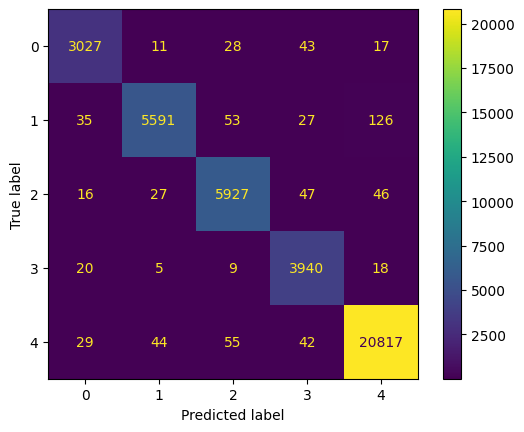

F1 Scores: {0: 0.9681752758675836, 1: 0.9715030408340574, 2: 0.97684384013185, 3: 0.9739216413298727, 4: 0.9910261598152865}


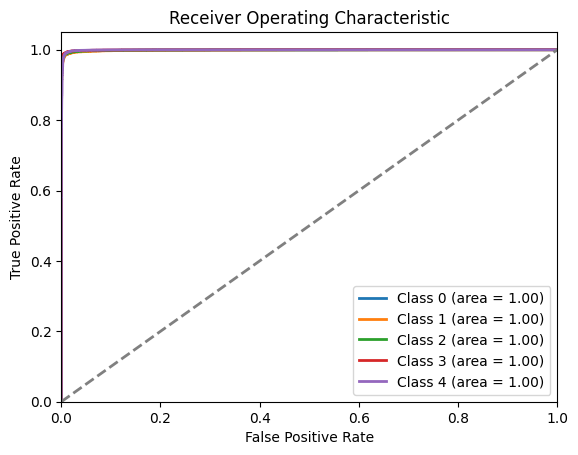

In [153]:
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
# Evaluate the model
loss, accuracy = model.evaluate(X_train, y_train_onehot)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Predictions
y_pred_prob = model.predict(X_train)
y_pred = np.argmax(y_pred_prob, axis=1)
y_train = np.argmax(y_train_onehot, axis=1)

# Accuracy
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

# Classification Report
print("Classification Report:\n", classification_report(y_train, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()
plt.show()

# F1 Scores
report = classification_report(y_train, y_pred, output_dict=True)
f1_scores = {label: report[str(label)]['f1-score'] for label in range(len(label_encoder.classes_))}
print("F1 Scores:", f1_scores)

# ROC Curve and AUC
y_train_bin = label_binarize(y_train, classes=range(len(label_encoder.classes_)))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = roc_auc_score(y_train_bin[:, i], y_pred_prob[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='Class %d (area = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 126ms/step - accuracy: 0.6755 - loss: 1.6778
Loss: 1.6613539457321167, Accuracy: 0.6776999831199646
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 150ms/step
Accuracy: 0.6777
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.37      0.38       799
           1       0.45      0.39      0.42      1424
           2       0.58      0.57      0.57      1587
           3       0.52      0.56      0.53       960
           4       0.83      0.86      0.85      5230

    accuracy                           0.68     10000
   macro avg       0.55      0.55      0.55     10000
weighted avg       0.67      0.68      0.67     10000



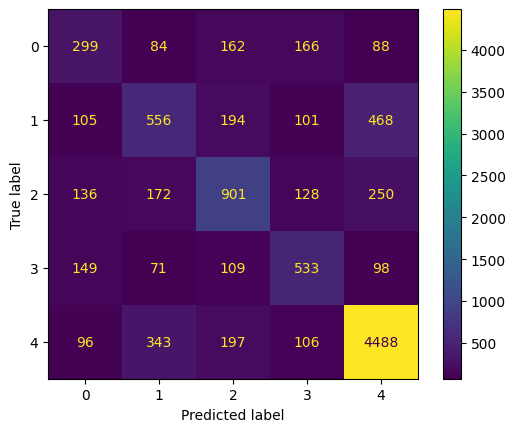

F1 Scores: {0: 0.37752525252525254, 1: 0.41962264150943396, 2: 0.572063492063492, 3: 0.5346038114343029, 4: 0.8450385991338731}


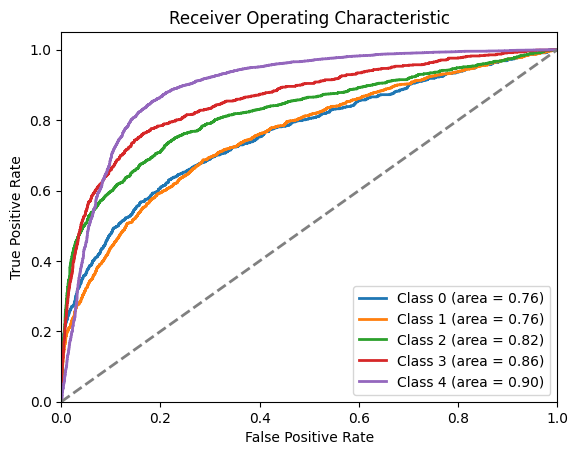

In [154]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_onehot)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Predictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test = np.argmax(y_test_onehot, axis=1)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()
plt.show()

# F1 Scores
report = classification_report(y_test, y_pred, output_dict=True)
f1_scores = {label: report[str(label)]['f1-score'] for label in range(len(label_encoder.classes_))}
print("F1 Scores:", f1_scores)

# ROC Curve and AUC
y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='Class %d (area = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Below is the overview. <br> Need to tune the model more efficiently <br> Might need more on pre-processing
| **Model**                | **Vectorization Technique**  | **Classifier**      | **Accuracy** |
|--------------------------|------------------------------|---------------------|--------------|
| TF-IDF(UNIGRAM)                | TF-IDF Vectorizer            | LinearSVC           |   64 with overfitting          |
| TF-IDF(BIGRAM)                   | TF-IDF Vectorizer            | LinearSVC           |   60 with overfitting           |
| CountVectorizer           | CountVectorizer              | LinearSVC           |  73 with overfitting          |
| Word2Vec (CBOW) | Word2Vec                     | LinearSVC           |        61 with overfitting     |
| Word2Vec (Skipgram) | Word2Vec                | LinearSVC           |       61 with overfitting       |
| GloVe                    | GloVe Embeddings             | LinearSVC           |     58 No overfitting         |
| FastText                 | FastText Embeddings          | LinearSVC           |    61 No overfitting          |
| RNN                      | Tokenizer                          | RNN                 |     66 on 1/10th data         |
| LSTM                     | Tokenizer                            | LSTM                |     68 on 1/15th data         |

